In [85]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set_theme()

In [114]:
column_names = [
    "age",
    "sex",
    "chest_pain_type",
    "bp",
    "cholesterol",
    "fbs_over_120",
    "ekg_results",
    "max_hr",
    "exercise_angina",
    "st_depression",
    "slope_of_st",
    "number_of_vessels_fluro",
    "thallium",
    "heart_disease"
]

columns_translated = {
    "age": "Idade",
    "sex": "Sexo",
    "chest_pain_type": "Tipo de Dor no Peito",
    "bp": "Pressão Arterial",
    "cholesterol": "Colesterol",
    "fbs_over_120": "Glicose em Jejum Acima de 120",
    "ekg_results": "Resultados do EKG",
    "max_hr": "Frequência Cardíaca Máxima",
    "exercise_angina": "Angina Induzida por Exercício",
    "st_depression": "Depressão ST",
    "slope_of_st": "Inclinação de ST",
    "number_of_vessels_fluro": "Número de Vasos Fluoroscópicos",
    "thallium": "Talio",
    "heart_disease": "Doença Cardíaca"
}



int_column_names = column_names.copy()
int_column_names.remove('st_depression')
path = r"C:\Users\Lucas\.cache\kagglehub\datasets\rishidamarla\heart-disease-prediction\versions\1"

In [44]:
column_names

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium',
 'heart_disease']

In [45]:
os.listdir(path)

['Heart_Disease_Prediction.csv']

In [46]:
df = pd.DataFrame(pd.read_csv(path+"\\Heart_Disease_Prediction.csv"))
df.columns = column_names
df['heart_disease'] = np.where(df['heart_disease'] == "Presence",1,0)
df['st_depression'] = df['st_depression'].astype('float32')
df[int_column_names] = df[int_column_names].astype('int16')
df.head()

,age,sex,chest_pain_type,bp,cholesterol,fbs_over_120,ekg_results,max_hr,exercise_angina,st_depression,slope_of_st,number_of_vessels_fluro,thallium,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
chest_pain_type,270.0,3.174074,0.950090,1.0,3.0,3.0,4.0,4.0
bp,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
cholesterol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
fbs_over_120,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
ekg_results,270.0,1.022222,0.997891,0.0,0.0,2.0,2.0,2.0
max_hr,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
exercise_angina,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
st_depression,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      270 non-null    int16  
 1   sex                      270 non-null    int16  
 2   chest_pain_type          270 non-null    int16  
 3   bp                       270 non-null    int16  
 4   cholesterol              270 non-null    int16  
 5   fbs_over_120             270 non-null    int16  
 6   ekg_results              270 non-null    int16  
 7   max_hr                   270 non-null    int16  
 8   exercise_angina          270 non-null    int16  
 9   st_depression            270 non-null    float32
 10  slope_of_st              270 non-null    int16  
 11  number_of_vessels_fluro  270 non-null    int16  
 12  thallium                 270 non-null    int16  
 13  heart_disease            270 non-null    int16  
dtypes: float32(1), int16(13)
m

In [49]:
# plt.figure(figsize=(10,8))
# pivot_table = df.pivot_table(index="age", columns="heart_disease", aggfunc="size", fill_value=0)
# sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")

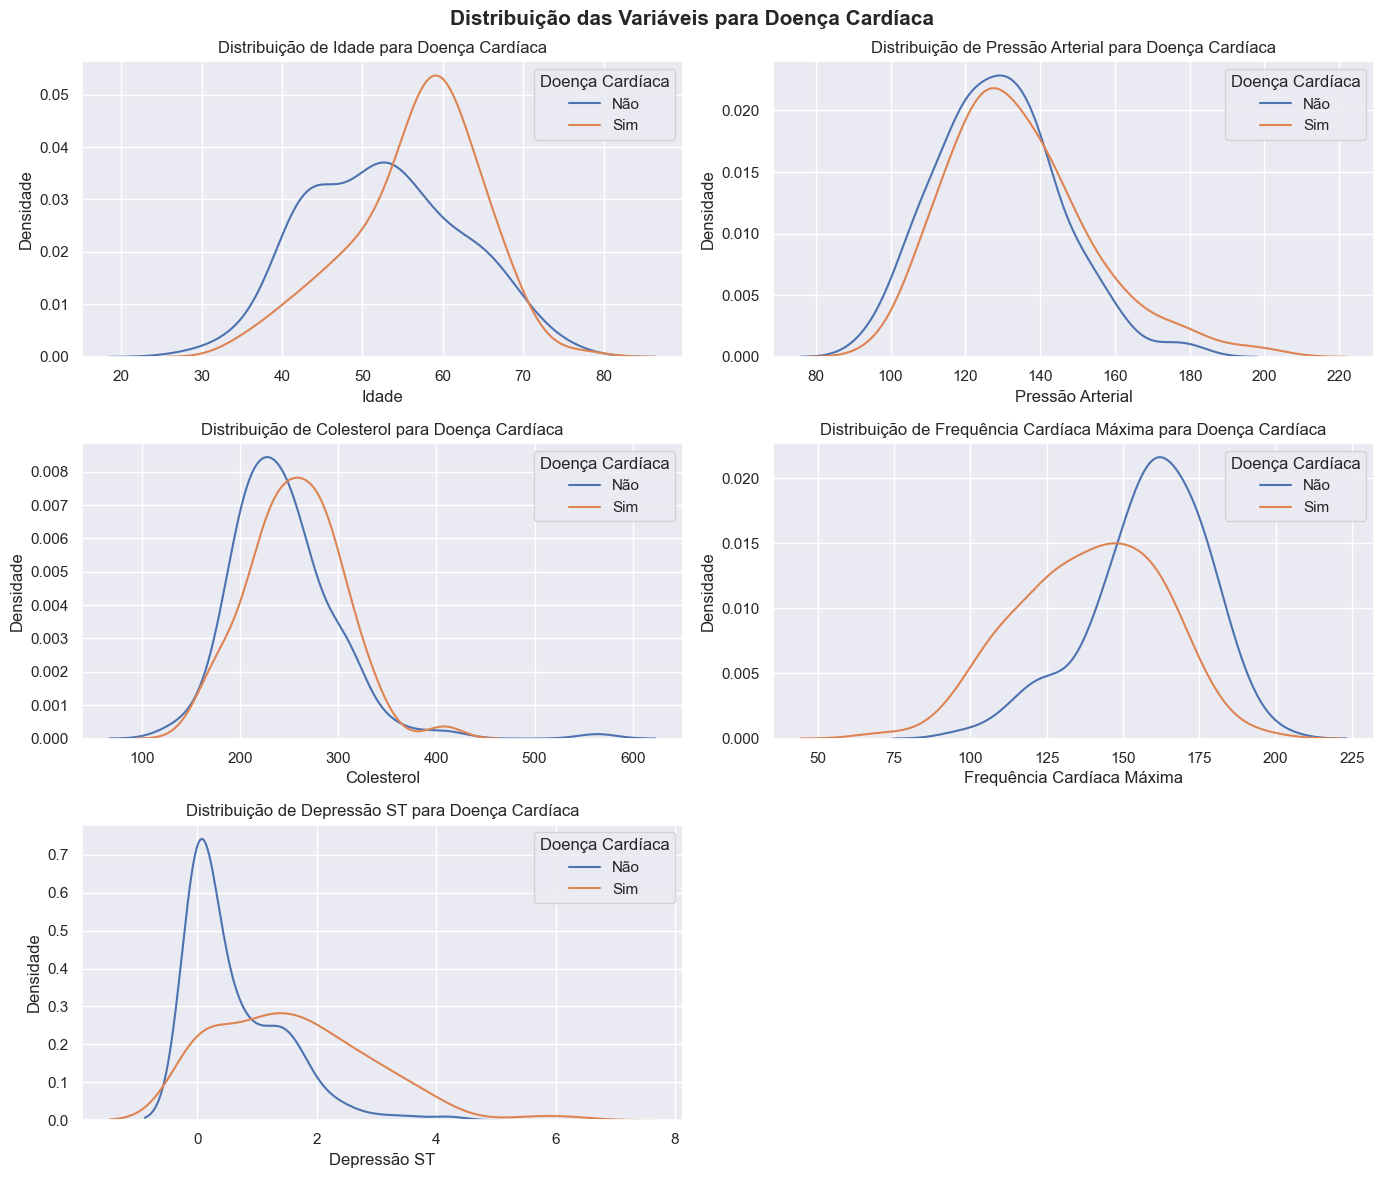

In [129]:
# Define the continuous columns to plot
columns = ["age", "bp", "cholesterol", "max_hr", "st_depression"]

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing


# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.kdeplot(df.loc[df['heart_disease'] == 0, col], label='Doença Cardíaca = 0', ax=axes[i])
    sns.kdeplot(df.loc[df['heart_disease'] == 1, col], label='Doença Cardíaca = 1', ax=axes[i])
    axes[i].set_ylabel('Densidade')
    axes[i].set_xlabel(columns_translated[col])
    axes[i].set_title(f'Distribuição de {columns_translated[col]} para Doença Cardíaca')
    axes[i].legend(title="Doença Cardíaca", labels=['Não', 'Sim'])


# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Distribuição das Variáveis para Doença Cardíaca', fontsize=15, fontweight='bold')

plt.tight_layout()
# plt.savefig('plot_distruicao_kde.png', dpi=300)
plt.show()

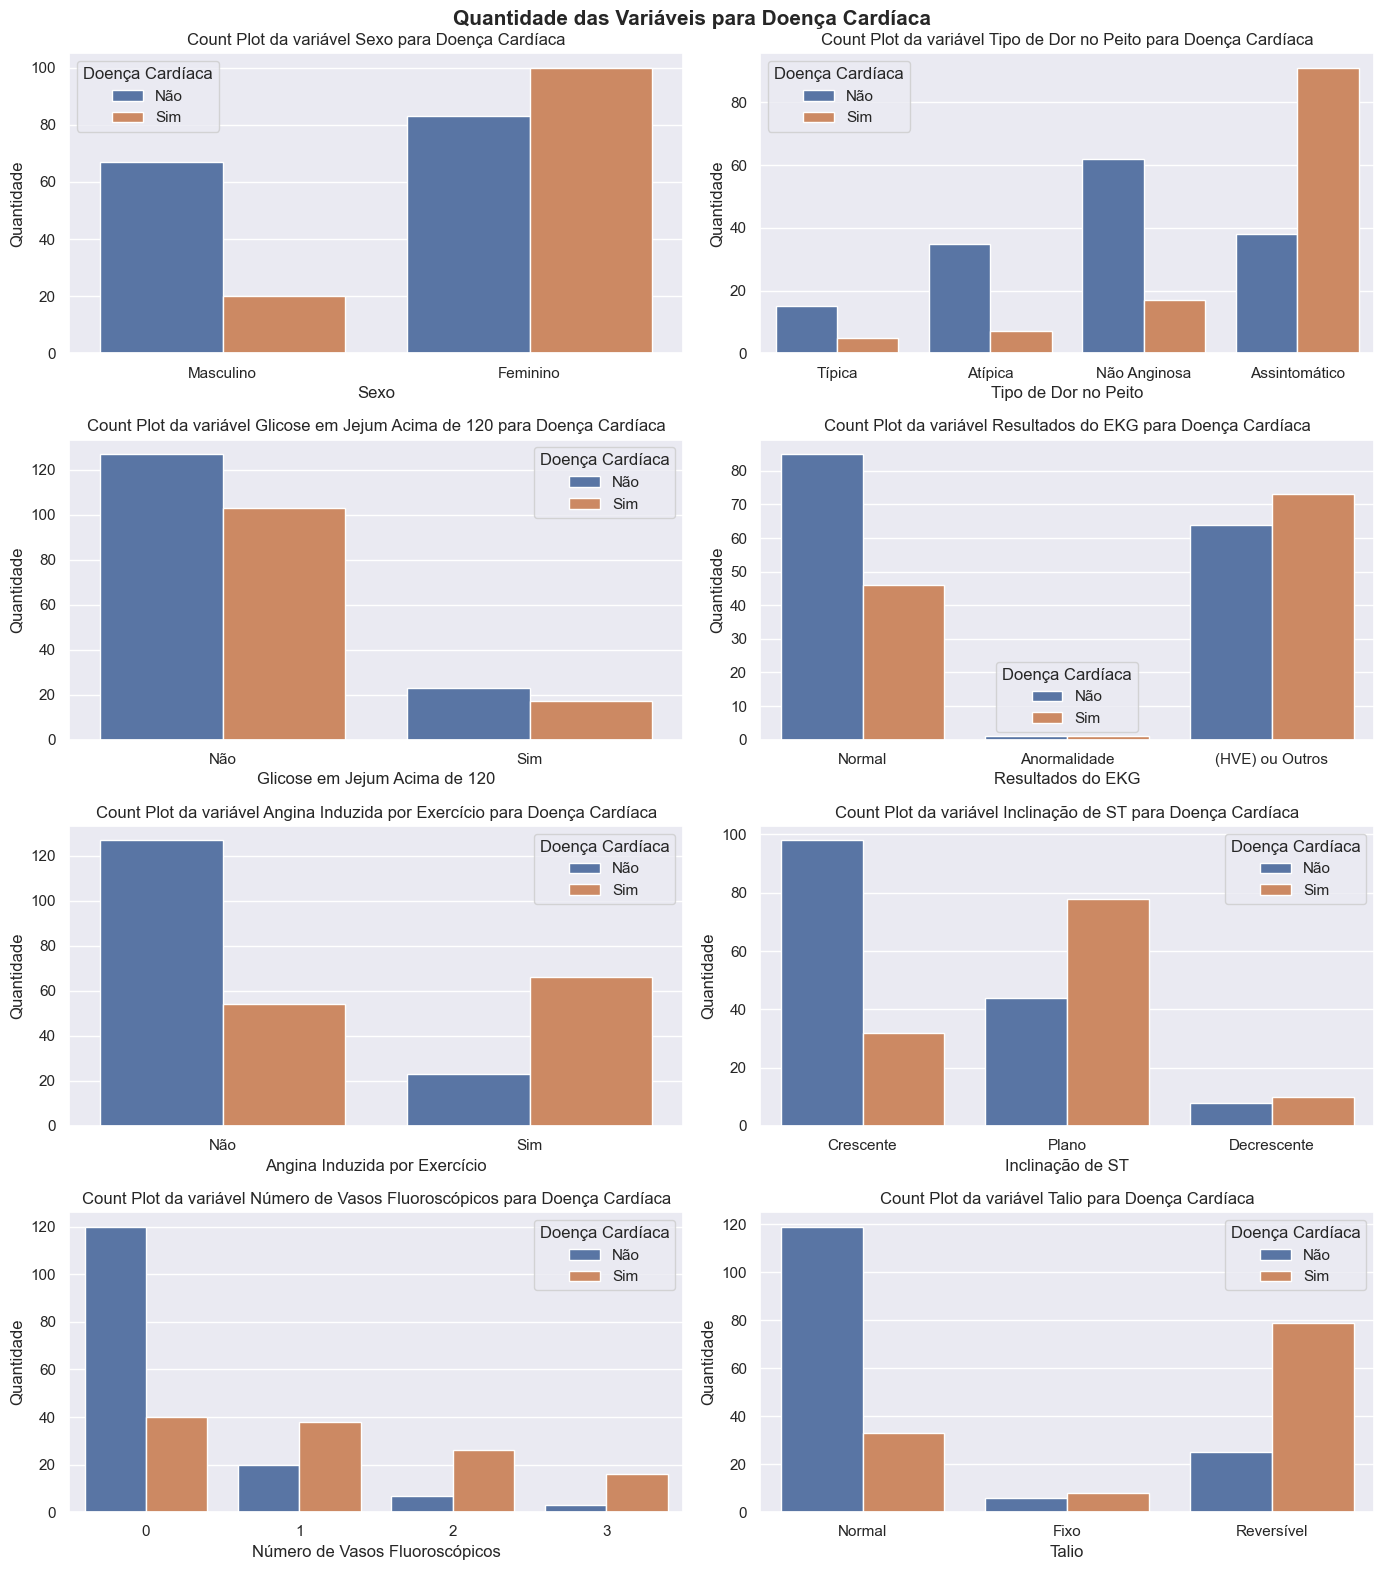

In [141]:
columns = ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
           'exercise_angina', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']

xtick_names = [['Masculino','Feminino'],
               ['Típica','Atípica','Não Anginosa','Assintomático'],
               ['Não','Sim'],
               ['Normal','Anormalidade','(HVE) ou Outros'],
               ['Não','Sim'],
               ['Crescente','Plano','Decrescente'],
               [0,1,2,3],
               ['Normal', 'Fixo', 'Reversível']]

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.countplot(x=df[col], hue=df['heart_disease'], ax=axes[i])
    axes[i].set_xticklabels(xtick_names[i])
    axes[i].set_title(f'Count Plot da variável {columns_translated[col]} para Doença Cardíaca')
    axes[i].set_ylabel('Quantidade')
    axes[i].set_xlabel(columns_translated[col])
    axes[i].legend(title="Doença Cardíaca", labels=['Não', 'Sim'])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Quantidade das Variáveis para Doença Cardíaca', fontsize=15, fontweight='bold')
    
plt.tight_layout()
# plt.savefig('plot_distruicao_count.png', dpi=300)
plt.show()

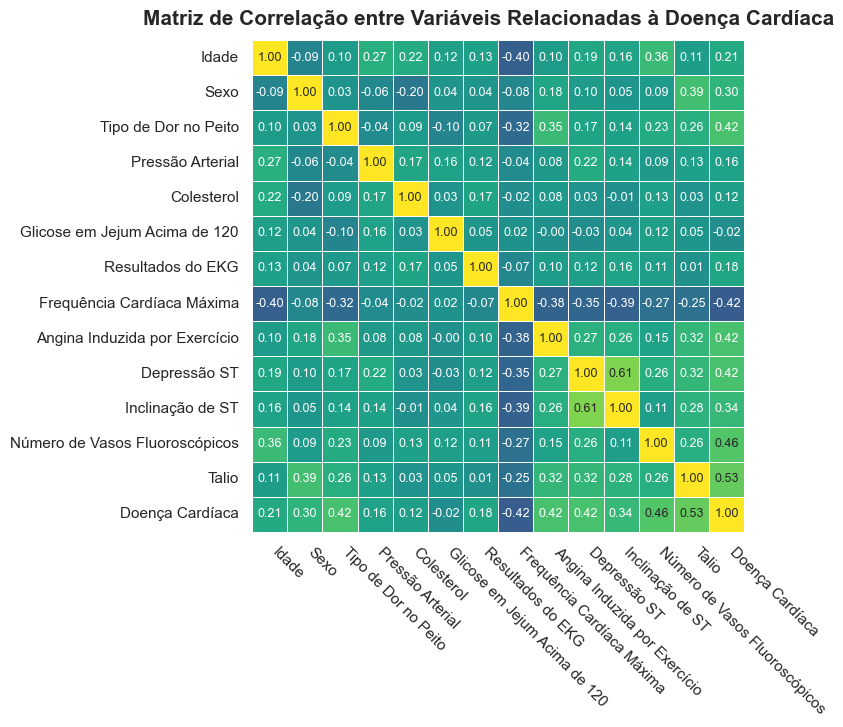

In [168]:
plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 9})
translated_labels = [columns_translated.get(col, col) for col in df.columns]
sns.heatmap(df.corr(), cmap='viridis', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f", 
            square=True, linewidths=0.5, 
            xticklabels=translated_labels, 
            yticklabels=translated_labels, cbar=False)
plt.suptitle("Matriz de Correlação entre Variáveis Relacionadas à Doença Cardíaca", fontsize=15, fontweight='bold')
plt.xticks(rotation=-45, ha='left')
plt.subplots_adjust(top=.93)
# plt.savefig('plot_distruicao_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

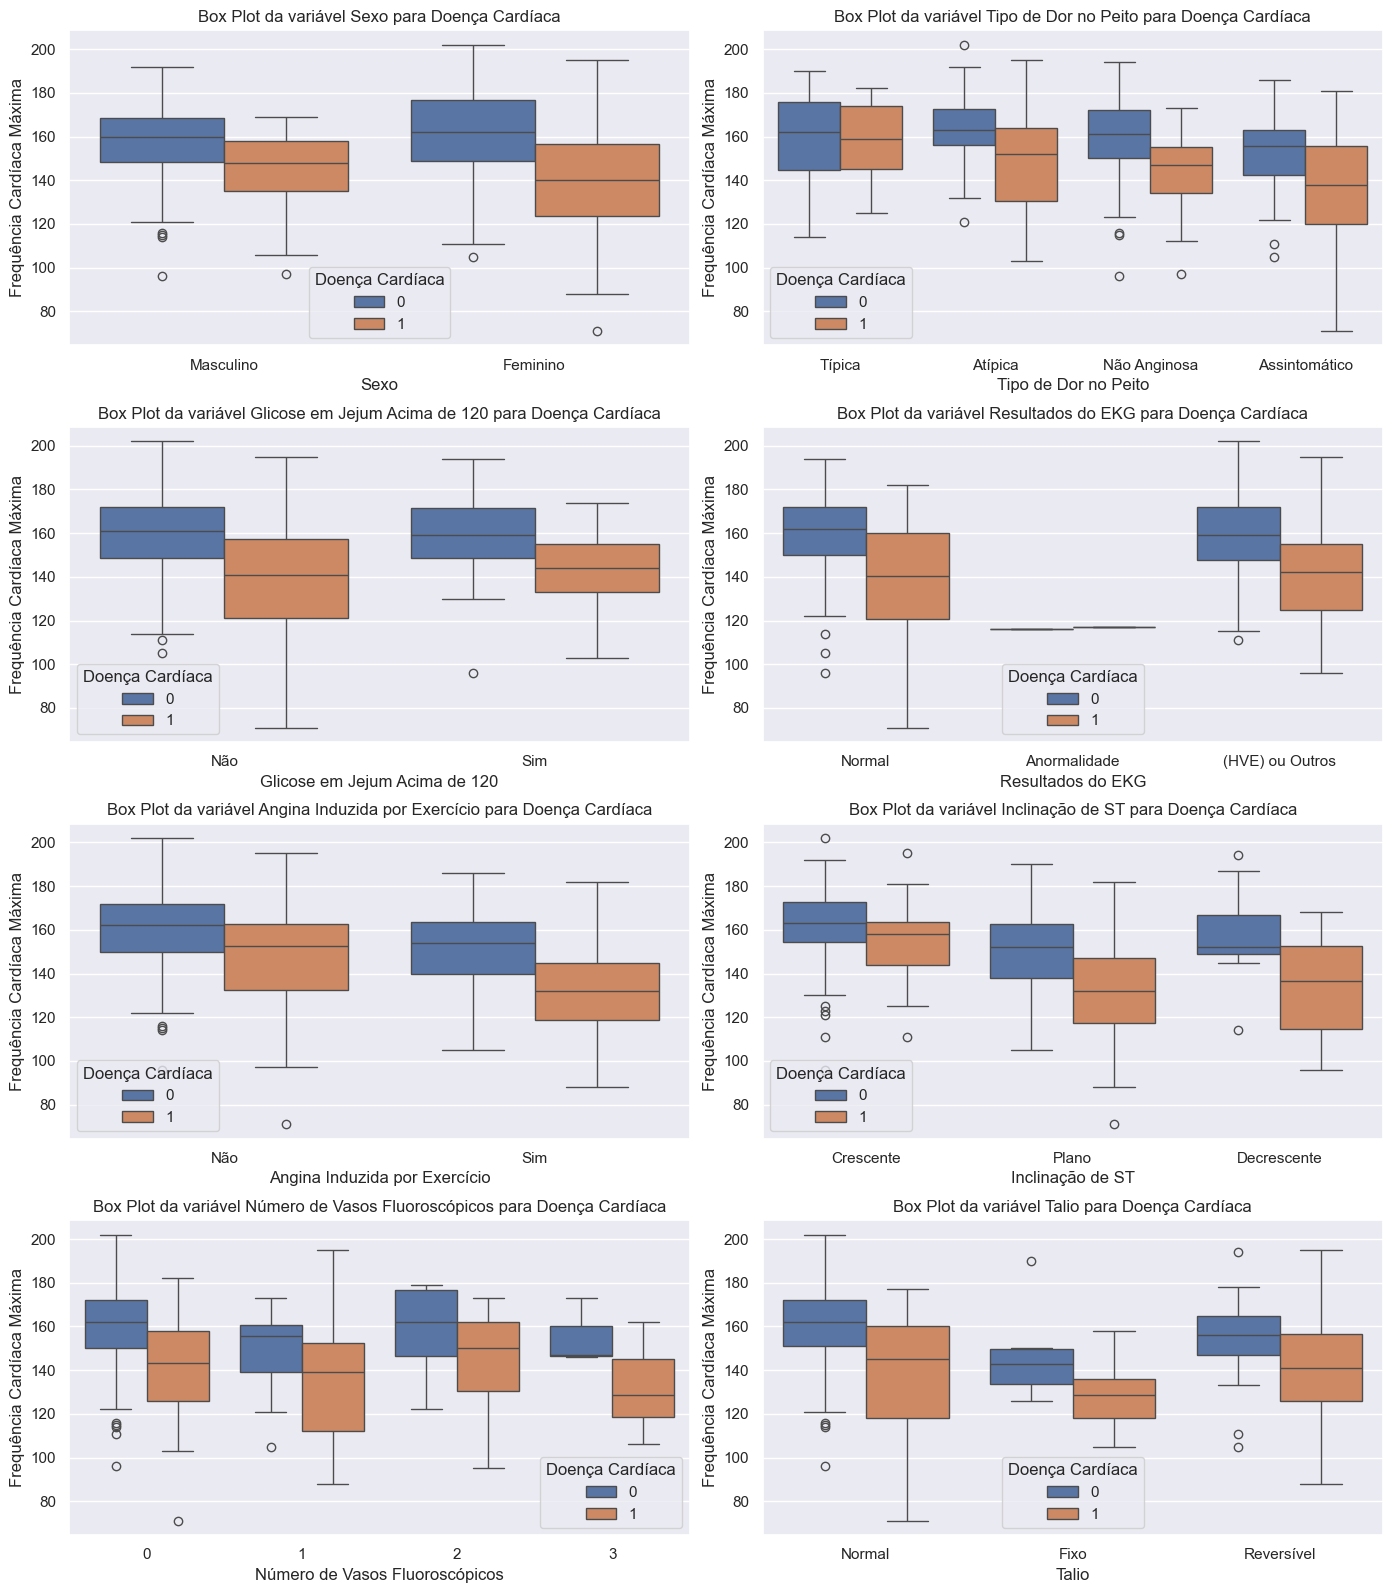

In [178]:
columns = ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
           'exercise_angina', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.boxplot(x=df[col],y=df['max_hr'], hue=df['heart_disease'], ax=axes[i])
    axes[i].set_xticklabels(xtick_names[i])
    axes[i].set_title(f'Box Plot da variável {columns_translated[col]} para Doença Cardíaca')
    axes[i].set_ylabel(columns_translated['max_hr'])
    axes[i].set_xlabel(columns_translated[col])
    axes[i].legend(title="Doença Cardíaca")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

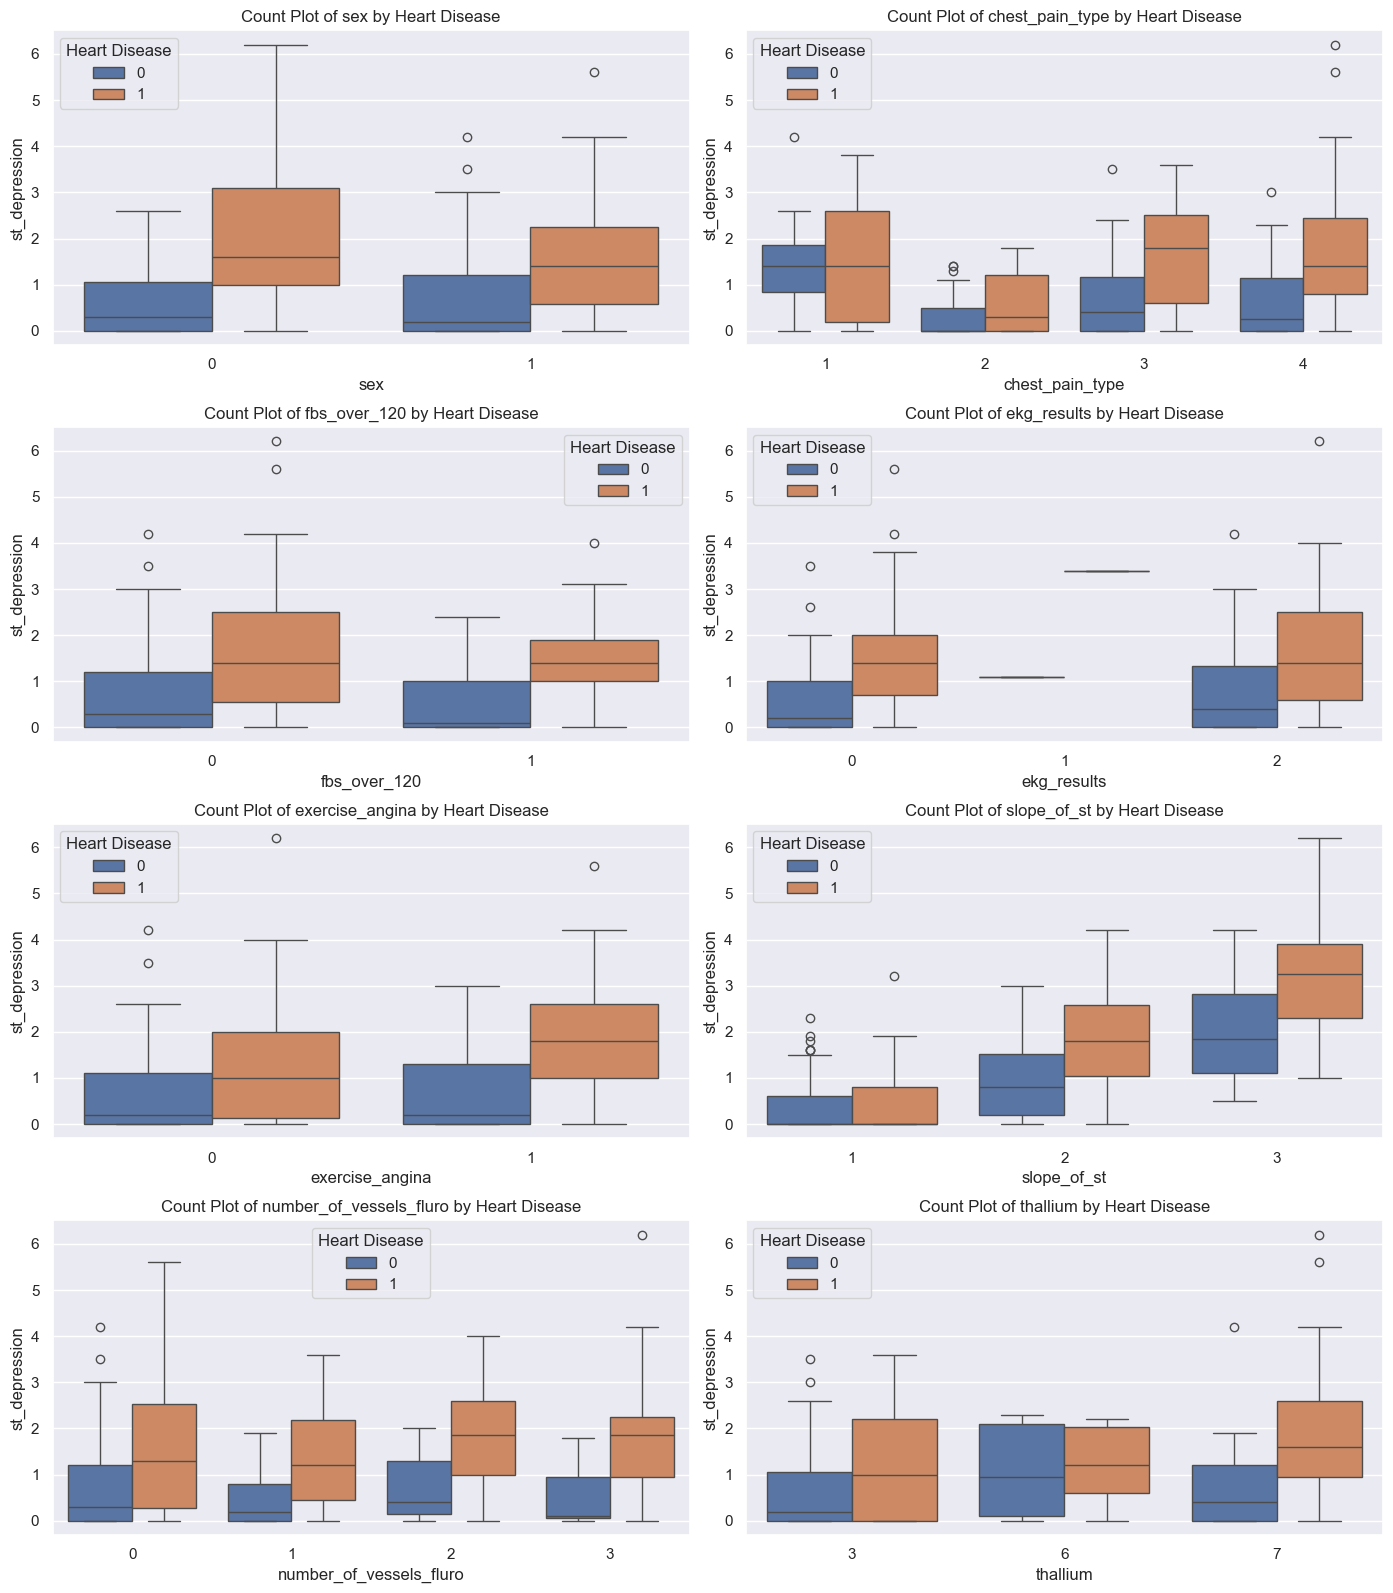

In [54]:
columns = ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
           'exercise_angina', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.boxplot(x=df[col],y=df['st_depression'], hue=df['heart_disease'], ax=axes[i])
    axes[i].set_title(f'Count Plot of {col} by Heart Disease')
    axes[i].legend(title="Heart Disease")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [55]:
xtrain, xval, ytrain, yval = train_test_split(df.drop(columns='heart_disease'), df['heart_disease'], test_size=0.2, random_state=42)
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)
models = {}

In [77]:
def fitGrid(pipe,paramns,x,y):
    grid = GridSearchCV(estimator=pipe,param_grid=paramns,cv=5,n_jobs=4,scoring='recall', verbose=0)
    grid.fit(x,y)
    return grid.best_estimator_

def fitRandomizedGrid(pipe,paramns,x,y):
    grid = RandomizedSearchCV(estimator=pipe,param_distributions=paramns,cv=5,n_jobs=4,scoring='recall', verbose=0, random_state=42)
    grid.fit(x,y)
    return grid.best_estimator_

In [78]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                    #  ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('logit', LogisticRegression())])

logit_params = {'logit__C':np.linspace(0.1,2,10)}

logit = fitRandomizedGrid(pipeline,logit_params,xtrain,ytrain)
y_pred = logit.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['logit'] = logit
print(recall_value)
print(classification_report(ytest,y_pred))

0.7222222222222222
              precision    recall  f1-score   support

           0       0.78      0.69      0.73        26
           1       0.62      0.72      0.67        18

    accuracy                           0.70        44
   macro avg       0.70      0.71      0.70        44
weighted avg       0.72      0.70      0.71        44



In [79]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                    #  ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('svc', SVC())])

svc_params = {'svc__C':np.linspace(0.1,2,10),
              'svc__kernel':['linear', 'rbf', 'sigmoid',],
              'svc__gamma':np.linspace(0.1,2,10)}

svc = fitRandomizedGrid(pipeline,svc_params,xtrain,ytrain)
y_pred = svc.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['svc'] = svc
print(recall_value)
print(classification_report(ytest,y_pred))

0.8333333333333334
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        26
           1       0.79      0.83      0.81        18

    accuracy                           0.84        44
   macro avg       0.83      0.84      0.84        44
weighted avg       0.84      0.84      0.84        44



In [80]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                    #  ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('rf', RandomForestClassifier(random_state=42))])

rf_params = {'rf__n_estimators':np.linspace(50,300,25).astype('int'),
              'rf__max_depth':np.arange(1,15,2).astype('int')}

rf = fitRandomizedGrid(pipeline,rf_params,xtrain,ytrain)
y_pred = rf.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['rf'] = rf
print(recall_value)
print(classification_report(ytest,y_pred))

0.8333333333333334
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        26
           1       0.71      0.83      0.77        18

    accuracy                           0.80        44
   macro avg       0.79      0.80      0.79        44
weighted avg       0.81      0.80      0.80        44



In [81]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                    #  ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

knn_params = {'knn__n_neighbors':np.arange(3,10),
              'knn__weights':['uniform','distance']}

knn = fitRandomizedGrid(pipeline,knn_params,xtrain,ytrain)
y_pred = knn.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['knn'] = knn
print(recall_value)
print(classification_report(ytest,y_pred))

0.7777777777777778
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        26
           1       0.70      0.78      0.74        18

    accuracy                           0.77        44
   macro avg       0.77      0.77      0.77        44
weighted avg       0.78      0.77      0.77        44



In [82]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                    #  ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('cb', CatBoostClassifier(random_state=42, verbose=0))])

cb_params = {'cb__max_depth':np.arange(1,7,2)}

cb = fitRandomizedGrid(pipeline,cb_params,xtrain,ytrain)
y_pred = cb.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['cb'] = cb
print(recall_value)
print(classification_report(ytest,y_pred))

0.7777777777777778
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.78      0.78      0.78        18

    accuracy                           0.82        44
   macro avg       0.81      0.81      0.81        44
weighted avg       0.82      0.82      0.82        44



In [84]:
# Com PCA
# for model in models.keys():
#     print(model,recall_score(yval,models[model].predict(xval)))
# logit 0.7619047619047619
# svc 0.6190476190476191
# rf 0.7142857142857143
# knn 0.6190476190476191
# cb 0.7619047619047619

In [107]:
# Sem PCA
temp = []
for model in models.keys():
    t = round(recall_score(yval,models[model].predict(xval)),3)
    temp.append(t)
    print(model,t)

logit 0.762
svc 0.524
rf 0.857
knn 0.714
cb 0.762


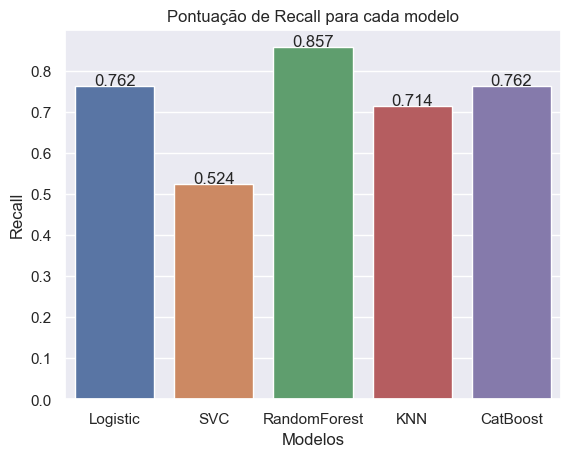

In [112]:
ax = sns.barplot(x=['Logistic','SVC','RandomForest','KNN','CatBoost'],y=temp, hue=['orange','green','red','yellow','blue'])
plt.legend([], [], frameon=False)

for i, v in enumerate(temp):
    ax.text(i, v + 0.003, str(v), ha='center')

plt.xlabel("Modelos")
plt.ylabel("Recall")
plt.title('Pontuação de Recall para cada modelo')
plt.savefig("recall_score.png",dpi=300)
plt.show()

In [87]:
with open('rf.pkl', 'wb') as file:
    pickle.dump(models['rf'], file)